In [36]:
# If pandas is not installed, please uncomment the following line:
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn


In [37]:
train_data = pd.read_csv("/content/train.csv")
test_data = pd.read_csv('/content/test.csv')

In [38]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [39]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [40]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [41]:
# If test data were inaccessible, mean and standard deviation could be
# calculated from training data
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [43]:
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape
all_features.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0


In [25]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [26]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [27]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [28]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [29]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [30]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.170292, valid log rmse 0.156180
fold 2, train log rmse 0.162476, valid log rmse 0.190371
fold 3, train log rmse 0.164181, valid log rmse 0.168299
fold 4, train log rmse 0.167929, valid log rmse 0.154656
fold 5, train log rmse 0.162949, valid log rmse 0.182901
5-fold validation: avg train log rmse: 0.165565, avg valid log rmse: 0.170481


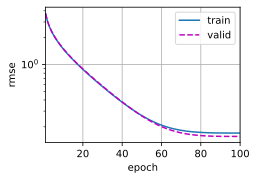

In [31]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

In [34]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = net(test_features).detach().numpy()
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.162590


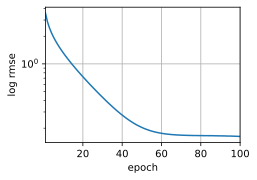

In [35]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

In [2]:
pip install keras-tuner --upgrade

     |████████████████████████████████| 133 kB 5.2 MB/s 


In [52]:
import pandas as pd #pandas use for reading the data
import numpy as np#numpy used for the mathematics
import matplotlib.pyplot as plt#matplotlib used for the data visualisation
import seaborn as sns#seaborn is also for visualise the data
from sklearn.preprocessing import StandardScaler#Standardising the data
from sklearn.ensemble import IsolationForest #isolation forest for the remove outliers
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping # Early Stopping Callback in the NN
from kerastuner.tuners import RandomSearch # HyperParameter Tunining
import plotly
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

In [53]:
train=pd.read_csv("/content/train.csv")

In [54]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [55]:
train.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [56]:
test = pd.read_csv('/content/test.csv')
y = train['SalePrice'].values
data = pd.concat([train,test],axis=0,sort=False)
data.drop(['SalePrice'],axis=1,inplace=True)
data.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

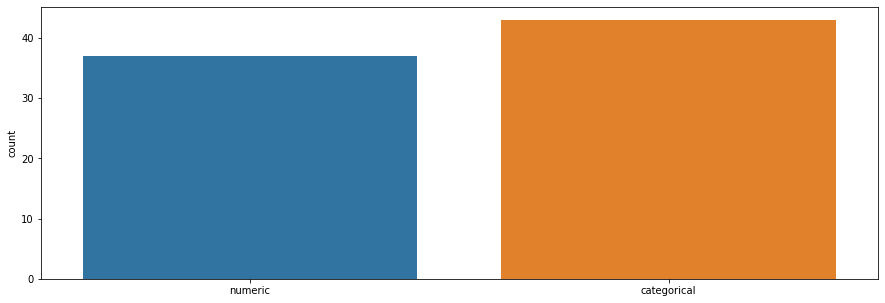

In [58]:
column_data_type = []
for col in data.columns:
    data_type = data[col].dtype
    if data[col].dtype in ['int64','float64']:
        column_data_type.append('numeric')
    else:
        column_data_type.append('categorical')
plt.figure(figsize=(15,5))
sns.countplot(x=column_data_type)
plt.show()

In [59]:
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending = False)
missing_values
NAN_col = list(missing_values.to_dict().keys())
missing_values_data = pd.DataFrame(missing_values)
missing_values_data.reset_index(level=0, inplace=True)
missing_values_data.columns = ['Feature','Number of Missing Values']
missing_values_data['Percentage of Missing Values'] = (100.0*missing_values_data['Number of Missing Values'])/len(data)
missing_values_data

,Feature,Number of Missing Values,Percentage of Missing Values
0,PoolQC,2909,99.657417
1,MiscFeature,2814,96.402878
2,Alley,2721,93.216855
3,Fence,2348,80.438506
4,FireplaceQu,1420,48.646797
5,LotFrontage,486,16.649538
6,GarageFinish,159,5.447071
7,GarageQual,159,5.447071
8,GarageCond,159,5.447071
9,GarageYrBlt,159,5.447071


In [60]:
data['BsmtFinSF1'].fillna(0, inplace=True)
data['BsmtFinSF2'].fillna(0, inplace=True)
data['TotalBsmtSF'].fillna(0, inplace=True)
data['BsmtUnfSF'].fillna(0, inplace=True)
data['Electrical'].fillna('FuseA',inplace = True)
data['KitchenQual'].fillna('TA',inplace=True)
data['LotFrontage'].fillna(data.groupby('1stFlrSF')['LotFrontage'].transform('mean'),inplace=True)
data['LotFrontage'].interpolate(method='linear',inplace=True)
data['MasVnrArea'].fillna(data.groupby('MasVnrType')['MasVnrArea'].transform('mean'),inplace=True)
data['MasVnrArea'].interpolate(method='linear',inplace=True)

In [61]:
for col in NAN_col:
    data_type = data[col].dtype
    if data_type == 'object':
        data[col].fillna('NA',inplace=True)
    else:
        data[col].fillna(data[col].mean(),inplace=True)

In [62]:
data['Total_Square_Feet'] = (data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['1stFlrSF'] + 
                                                                 data['2ndFlrSF'] + data['TotalBsmtSF'])

data['Total_Bath'] = (data['FullBath'] + (0.5 * data['HalfBath']) + data['BsmtFullBath'] + 
                                                                  (0.5 * data['BsmtHalfBath']))

data['Total_Porch_Area'] = (data['OpenPorchSF'] + data['3SsnPorch'] + 
                                                data['EnclosedPorch'] + data['ScreenPorch'] + data['WoodDeckSF'])

data['SqFtPerRoom'] = data['GrLivArea'] / (data['TotRmsAbvGrd'] + data['FullBath'] +
                                                       data['HalfBath'] + data['KitchenAbvGr'])

In [63]:
data=pd.get_dummies(data)
data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_NA,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,0,0,0,1,0,0,0,0,1,0


In [64]:
train = data[:1460].copy()
test = data[1460:].copy()
train['SalePrice'] = y
train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,0,1,0,0,0,0,1,0,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,0,0,1,0,0,0,0,1,0,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,0,1,0,0,0,0,1,0,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,0,1,1,0,0,0,0,0,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,0,0,1,0,0,0,0,1,0,250000


<AxesSubplot:>

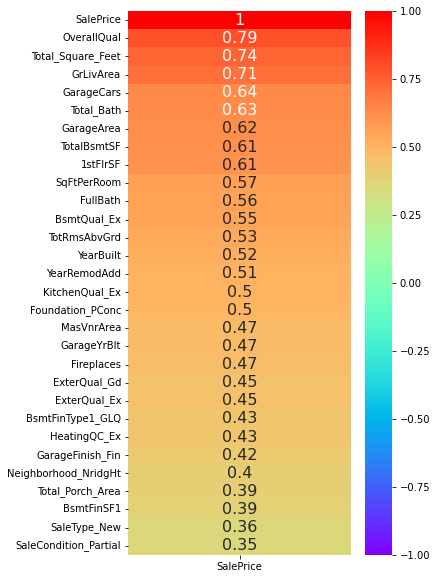

In [65]:
top_features = train.corr()[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(30)
plt.figure(figsize=(5,10))
sns.heatmap(top_features,cmap='rainbow',annot=True,annot_kws={"size": 16},vmin=-1)

In [66]:
def plot_data(col, discrete=False):
    if discrete:
        fig, ax = plt.subplots(1,2,figsize=(14,6))
        sns.stripplot(x=col, y='SalePrice', data=train, ax=ax[0])
        sns.countplot(train[col], ax=ax[1])
        fig.suptitle(str(col) + ' Analysis')
    else:
        fig, ax = plt.subplots(1,2,figsize=(12,6))
        sns.scatterplot(x=col, y='SalePrice', data=train, ax=ax[0])
        sns.distplot(train[col], kde=False, ax=ax[1])
        fig.suptitle(str(col) + ' Analysis')

In [67]:
def plot_data(col, discrete=False):
    if discrete:
        fig, ax = plt.subplots(1,2,figsize=(14,6))
        sns.stripplot(x=col, y='SalePrice', data=train, ax=ax[0])
        sns.countplot(train[col], ax=ax[1])
        fig.suptitle(str(col) + ' Analysis')
    else:
        fig, ax = plt.subplots(1,2,figsize=(12,6))
        sns.scatterplot(x=col, y='SalePrice', data=train, ax=ax[0])
        sns.distplot(train[col], kde=False, ax=ax[1])
        fig.suptitle(str(col) + ' Analysis')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



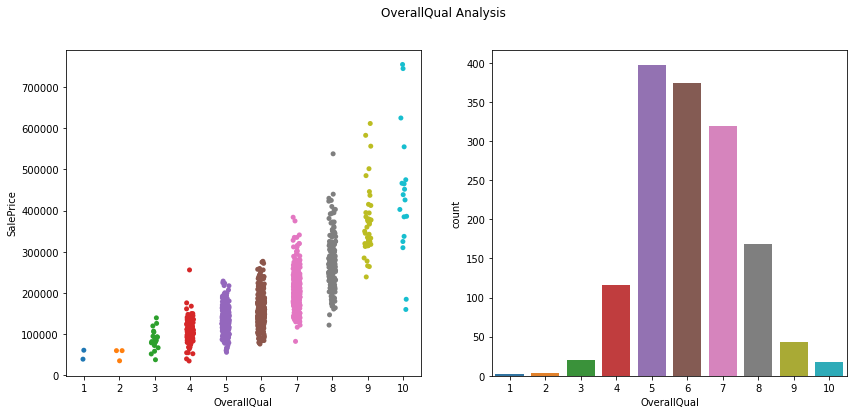

In [68]:
plot_data('OverallQual',True)

In [69]:
train = train.drop(train[(train['OverallQual'] == 10) & (train['SalePrice'] < 200000)].index)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



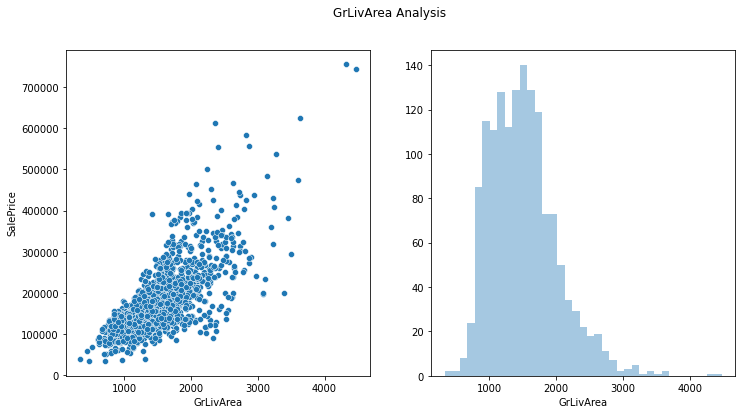

In [70]:
plot_data('GrLivArea')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



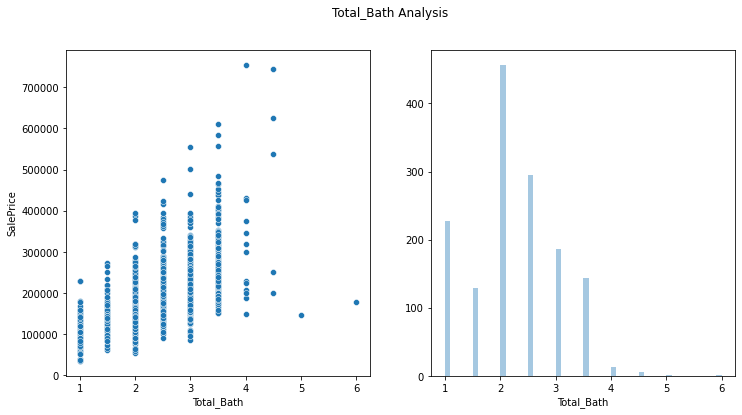

In [71]:
plot_data('Total_Bath')

In [72]:
train = train.drop(train[(train['Total_Bath'] > 4) & (train['SalePrice'] < 200000)].index)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



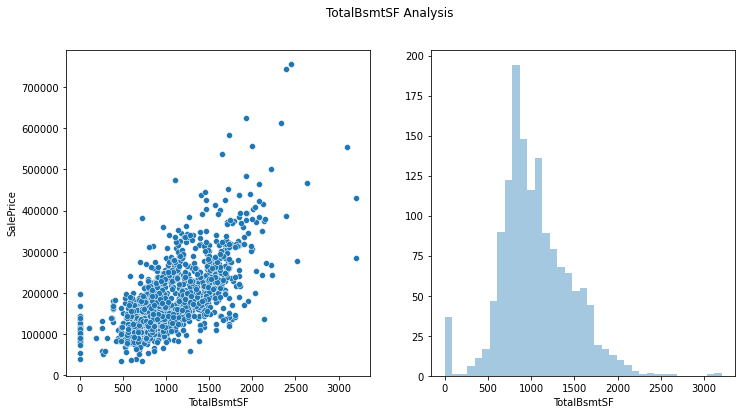

In [73]:
plot_data('TotalBsmtSF')

In [74]:
train = train.drop(train[(train['TotalBsmtSF'] > 3000) & (train['SalePrice'] < 400000)].index)

In [35]:
train.reset_index()

,index,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,0,1,60,65.0,8450,7,5,2003,2003,196.0,...,0,0,1,0,0,0,0,1,0,208500
1,1,2,20,80.0,9600,6,8,1976,1976,0.0,...,0,0,1,0,0,0,0,1,0,181500
2,2,3,60,68.0,11250,7,5,2001,2002,162.0,...,0,0,1,0,0,0,0,1,0,223500
3,3,4,70,60.0,9550,7,5,1915,1970,0.0,...,0,0,1,1,0,0,0,0,0,140000
4,4,5,60,84.0,14260,8,5,2000,2000,350.0,...,0,0,1,0,0,0,0,1,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,1455,1456,60,62.0,7917,6,5,1999,2000,0.0,...,0,0,1,0,0,0,0,1,0,175000
1451,1456,1457,20,85.0,13175,6,6,1978,1988,119.0,...,0,0,1,0,0,0,0,1,0,210000
1452,1457,1458,70,66.0,9042,7,9,1941,2006,0.0,...,0,0,1,0,0,0,0,1,0,266500
1453,1458,1459,20,68.0,9717,5,6,1950,1996,0.0,...,0,0,1,0,0,0,0,1,0,142125


In [36]:
clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 18
Number of rows without outliers: 1437


In [37]:
X = train.copy()
X.drop(['SalePrice'],axis=1,inplace=True)
y = train['SalePrice'].values
X.shape,y.shape

((1437, 314), (1437,))

In [38]:
scale = StandardScaler()
X = scale.fit_transform(X)

In [39]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('layers', 2, 10)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(Dense(1))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mse'])
    return model


In [40]:
tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=10,
    executions_per_trial=3,
    directory='model_dir',
    project_name='House_Price_Prediction')
tuner.search_space_summary()

Search space summary
Default search space size: 4
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [41]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(320, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(384, activation='relu'))
    model.add(Dense(352, activation='relu'))
    model.add(Dense(448, activation='relu'))
    model.add(Dense(160, activation='relu'))
    model.add(Dense(160, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss = 'mse')
    return model

In [42]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 320)               100800    
                                                                 
 dense_4 (Dense)             (None, 384)               123264    
                                                                 
 dense_5 (Dense)             (None, 352)               135520    
                                                                 
 dense_6 (Dense)             (None, 448)               158144    
                                                                 
 dense_7 (Dense)             (None, 160)               71840     
                                                                 
 dense_8 (Dense)             (None, 160)               25760     
                                                                 
 dense_9 (Dense)             (None, 32)               

In [44]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(x=X,y=y,
          validation_split=0.1,
          batch_size=128,epochs=100, callbacks=[early_stop])

Epoch 1/100
11/11 [==============================] - 0s 13ms/step - loss: 229078432.0000 - val_loss: 548208640.0000
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 225926016.0000 - val_loss: 559704640.0000
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 227382368.0000 - val_loss: 547111232.0000
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 221903248.0000 - val_loss: 540750400.0000
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 218280544.0000 - val_loss: 548622784.0000
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 217500352.0000 - val_loss: 545713408.0000
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 214550416.0000 - val_loss: 543641664.0000
Epoch 8/100
11/11 [==============================] - 0s 7ms/step - loss: 211875488.0000 - val_loss: 545023744.0000
Epoch 9/100
11/11 [==============================] - 0s 7ms/step - loss: 209391

<AxesSubplot:>

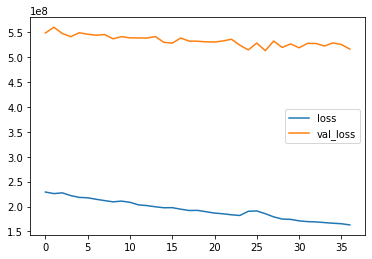

In [45]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [46]:
model=create_model()
history = model.fit(x=X,y=y,
          batch_size=128,epochs=170)

Epoch 1/170
12/12 [==============================] - 1s 8ms/step - loss: 39315234816.0000
Epoch 2/170
12/12 [==============================] - 0s 9ms/step - loss: 39314661376.0000
Epoch 3/170
12/12 [==============================] - 0s 9ms/step - loss: 39312982016.0000
Epoch 4/170
12/12 [==============================] - 0s 9ms/step - loss: 39307681792.0000
Epoch 5/170
12/12 [==============================] - 0s 9ms/step - loss: 39290781696.0000
Epoch 6/170
12/12 [==============================] - 0s 8ms/step - loss: 39237718016.0000
Epoch 7/170
12/12 [==============================] - 0s 11ms/step - loss: 39081218048.0000
Epoch 8/170
12/12 [==============================] - 0s 7ms/step - loss: 38662410240.0000
Epoch 9/170
12/12 [==============================] - 0s 7ms/step - loss: 37630963712.0000
Epoch 10/170
12/12 [==============================] - 0s 10ms/step - loss: 35235643392.0000
Epoch 11/170
12/12 [==============================] - 0s 8ms/step - loss: 30566234112.0000
Epoch 

<AxesSubplot:>

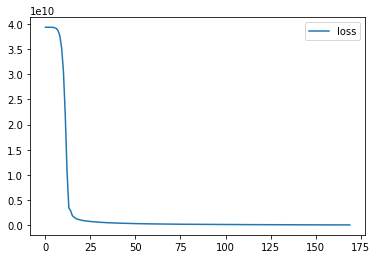

In [47]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [48]:
model.evaluate(X,y)

45/45 [==============================] - 1s 5ms/step - loss: 111184048.0000


111184048.0

In [49]:
X_test = scale.transform(test)
result = model.predict(X_test)
result = pd.DataFrame(result,columns=['SalePrice'])
result.head()
result['Id'] = test['Id']
result = result[['Id','SalePrice']]
result.head()

,Id,SalePrice
0,1461,130063.953125
1,1462,179094.796875
2,1463,194491.406250
3,1464,189632.078125
4,1465,180029.406250


In [51]:
result.to_csv('submission.csv',index=False)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#import warnings
#warnings.filterwarnings('ignore')
import seaborn as sns

In [4]:
train_dataset = pd.read_csv('/content/train.csv')
test_dataset = pd.read_csv('/content/test.csv')

In [5]:
train_dataset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
%matplotlib inline
train_dataset.hist(bins=50, figsize=(16,16))
plt.show()